In [1]:
import spacy
from collections import Counter, defaultdict
from matplotlib import pyplot as plt
import torch
from scipy.stats import zipf
from scipy.sparse import coo_matrix
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

import sys

### Warmup: computing word frequencies
#### Most frequent words

In [2]:
file_names = ['books.txt','europarl.txt','wikipedia.txt']
encodings = ['ISO-8859-1','utf-8','utf-8']
base_dir = 'C:/Users/Colton/OneDrive/School/Machine Learning for Natural Language Processing/HW_1/a1_data/'

In [3]:
def get_frequency_counter(file_name,encoding):
    freqs = Counter()
    with open(base_dir + file_name, encoding = encoding) as f:
        for line in f:
            tokens = line.lower().split()
            for token in tokens:
                freqs[token] += 1
    return freqs

In [4]:
freqs = {}
for i in range(len(file_names)):
    file_name = file_names[i]
    encoding = encodings[i]
    freqs[file_name] = get_frequency_counter(file_name, encoding)
    print('--------------' + file_name + '-------------')
    for word, freq in freqs[file_name].most_common(10):
        print(word + '\t' + str(freq))
most_frequent_words = freqs

--------------books.txt-------------
the	2425678
,	2064433
.	1958494
and	1367843
of	1321821
to	1159024
a	1103939
is	792900
in	739009
i	704436
--------------europarl.txt-------------
the	3003965
,	2115604
.	1536632
of	1422333
to	1341441
and	1158234
in	945160
that	732156
a	674231
is	671969
--------------wikipedia.txt-------------
the	3158463
,	2566261
.	1956600
of	1534698
and	1260516
in	1205759
a	958283
to	926287
-	548244
is	522101


Unsurprisingly, the most frequent tokens in all corpora are stop words and punctuation.

#### dictionary-within-dictionary

In [6]:
print('Most common words following "red"')
for i in range(len(file_names)):
    file_name = file_names[i]
    encoding = encodings[i]
    freqs = defaultdict(Counter)
    with open(base_dir+file_name, encoding=encoding) as f:
        for line in f:
            tokens = line.lower().split()
            for t1, t2 in zip(tokens, tokens[1:]):
                freqs[t1][t2] += 1
    word = freqs['red'].most_common(1)[0][0]
    freq = freqs['red'].most_common(1)[0][1]
    print(file_name + ':\t' + word + '\t' + str(freq))

Most common words following "red"
books.txt:	sox	198
europarl.txt:	tape	856
wikipedia.txt:	,	532


Since I'm taking .lower(), the words "square" and "Square" are considered equivalent. In reality, "red square" and "Red Square" aren't really the same thing. But with the amount of context we're given for the question (not really sure why we're looking at "red") I felt it was appropriate.

### Investigating the word frequency distribution

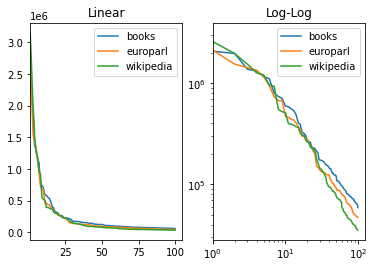

In [7]:
word_freqs = []
x = np.arange(1,101)
plt.subplot(121)
for i in range(len(file_names)):
    file_name = file_names[i]
    word_freqs.append([y[1] for y in most_frequent_words[file_name].most_common(100)])
    plt.plot(x, word_freqs[i], label=file_name[:-4])
    plt.xlim(xmin=1)
plt.legend()
plt.title('Linear')
    
plt.subplot(122)
for i in range(len(word_freqs)):
    plt.loglog(word_freqs[i],label=file_names[i][:-4])
    plt.xlim(xmin=1)
plt.legend()
plt.title('Log-Log')
plt.show()

Clearly, the most frequent words dominate. If we are using a bag-of-words model, a decent prediction for the next word in a sequence might just be to pick one of the most common ones. 
#### Zipf's Law
states that the frequency is inversely proportional to the rank. This means that for 

* rank *r(word)* = the rank of the word
* frequency *freq(word)* = the number of times the word appears
* corpus size *N* = the total number of (non-unique) tokens

Then for some constant *A*
* r(word) * freq(word) / N = A

i.e. we should see a constant slope in the above log-log plot, which we do if we omit the most common words (Zipf's Law is most likely to fail at either tail).

In [9]:
freqs = most_frequent_words
print('---Statistics for A---')
for file_name in file_names:
    r = np.arange(1, len(freqs[file_name].most_common()) + 1)
    freq = [x[1] for x in freqs[file_name].most_common()]
    N = np.sum(freq)
    dat = r * freq / N
    print(file_name + '\tMean: ' + str(np.mean(dat)) + '\tVar: ' + str(np.var(dat)))

---Statistics for A---
books.txt	Mean: 0.010557663090296697	Var: 0.00014799490652797688
europarl.txt	Mean: 0.009492457858733313	Var: 0.0003284536677340708
wikipedia.txt	Mean: 0.014199945956610468	Var: 0.00011211145505327055


In most cases A = 0.01 according to a quick Google. Our data fits Zipf's Law pretty well.

### Comparing corpora

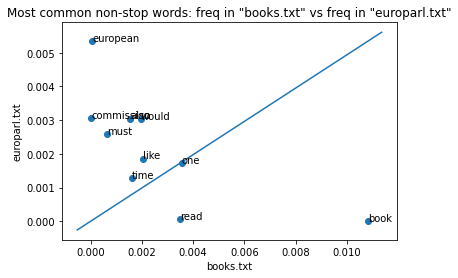

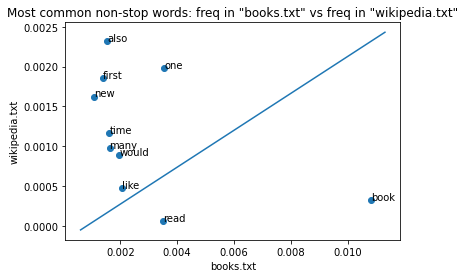

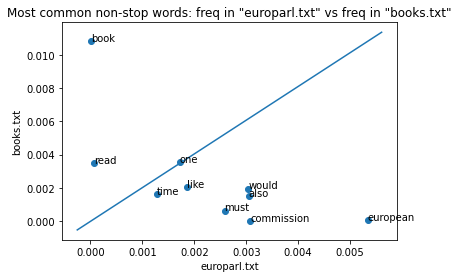

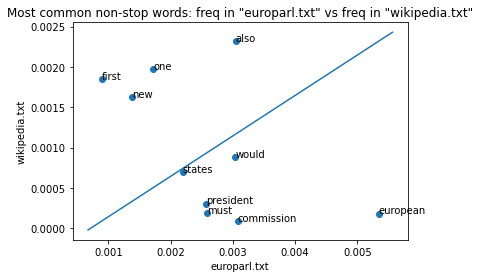

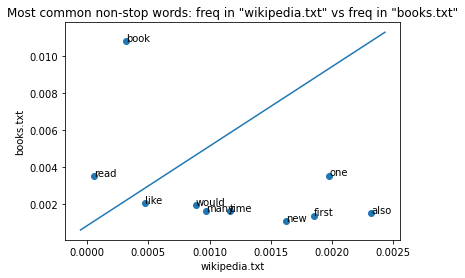

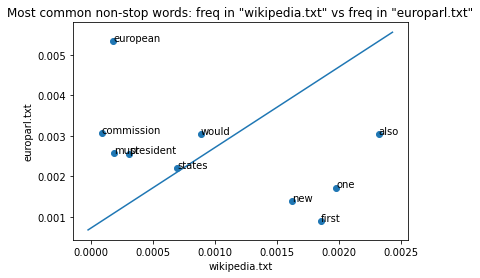

In [21]:
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')

number_to_compare = 10
freqs = most_frequent_words
for i in range(len(file_names)):
    file_name_1 = file_names[i]
    for j in range(len(file_names)):
        file_name_2 = file_names[j]
        if file_name_1 == file_name_2:
            continue
        combined_freqs = freqs[file_name_1] + freqs[file_name_2]
        most_common_words = [tup[0] for tup in combined_freqs.most_common()]
        most_common_nonstop = [word for word in most_common_words if not word in stop_words] 
        combined_corpus = tokenizer.tokenize(' '.join(most_common_nonstop)) # remove non-words
        most_common = [word for word in combined_corpus if len(word) > 2] # remove very short words
        relative_freq_1 = []
        relative_freq_2 = []
        for i in range(number_to_compare):
            relative_freq_1.append(freqs[file_name_1][most_common[i]] / sum(freqs[file_name_1].values()))
            relative_freq_2.append(freqs[file_name_2][most_common[i]] / sum(freqs[file_name_2].values()))
            
#         relative_freq_1 = [freqs[file_name_1][most_common] / sum(freqs[file_name_1].values()) for tup in top_10_counter]
#         relative_freq_2 = []
#         for word in top_10_words:
#             relative_freq_2.append(freqs[file_name_2][word] / sum(freqs[file_name_2].values()))
            
        fig, ax = plt.subplots()
        ax.scatter(relative_freq_1, relative_freq_2)
        ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [ax.get_ylim()[0], ax.get_ylim()[1]])
        for i, word in enumerate(most_common[:number_to_compare]):
            ax.annotate(word, (relative_freq_1[i], relative_freq_2[i]))
        ax.set_xlabel(file_name_1)
        ax.set_ylabel(file_name_2)
        ax.set_title('Most common non-stop words: freq in "' + file_name_1 + '" vs freq in "' + file_name_2 + '"')

These plots show the 10 most common non-stop words from the concatenation of two datasets, plotted as a function of their normalized frequency in *x* vs *y*. When a point appears above *y=x*, it occurs more often in the y-dataset, i.e. it has a higher rank in *y* than it does in *x*, and vice-versa.

### Side show: preprocessing text for machine learning

In [22]:
class Vocab:
    def __init__(self, dataset, max_voc_size=1000, batch_size=1000):
        self.split_dataset = dataset.split('\n')
        self.num_lines = len(self.split_dataset)
        if self.num_lines < batch_size:
            self.batch_size = self.num_lines
        else:
            self.batch_size = batch_size
        
        self.max_line_length = max([len(line.split()) for line in self.split_dataset])
        
        self.num_batches = int( np.floor(self.num_lines / self.batch_size) + \
                               (np.mod(self.num_lines, self.batch_size) > 0) )
        
        ############# word-to-int mapping #############
        self.max_voc_size = max_voc_size
        self.batch_size = batch_size
        freqs = Counter()
        tokens = dataset.lower().split()
        for token in tokens:
            freqs[token] += 1                                 # freqs is dict(), i.e. freqs[word] = count
        if len(freqs) > max_voc_size:
            voc_size = max_voc_size
        else:
            voc_size = len(freqs)
        freqs = freqs.most_common(voc_size)                   # now freqs is tuple of (word, count)
        mapping = {freqs[i][0]:i+1 for i in range(voc_size)}  # mapping is dict of freqs[word]=r where r=rank
        self.mapping = mapping
        

    def get_batch(self, batch_nbr):
        batch = np.zeros((self.max_line_length, self.batch_size))               # 0 is the padding
        line_lower_lim = batch_nbr * self.batch_size
        if (batch_nbr + 1) * self.batch_size > len(self.split_dataset):
            line_upper_lim = len(self.split_dataset)
        else:
            line_upper_lim = (batch_nbr + 1) * self.batch_size

        i = 0
        for line_idx in range(line_lower_lim, line_upper_lim):
            split_line = self.split_dataset[line_idx].split()
            for word_idx in range(len(split_line)):
                batch[word_idx][i] = self.mapping.get(split_line[word_idx], -1)  # -1 is default value
            i += 1
                
        return batch
        
i = 0 # file_names = ['books.txt','europarl.txt','wikipedia.txt']
max_voc_size=1000
batch_size=1000
with open(base_dir+file_names[i], encoding=encodings[i]) as f:
    dataset = f.read()
    
vc = Vocab(dataset, max_voc_size)
keys = ['the', 'ate', 'not', 'why', 'way', 'yes']
for key in keys:
    print('Key: ' + str(key) + '\tRank: ' + str(vc.mapping.get(key, -1)))
    
b = vc.get_batch(0)
print('Batch shape = ' + str(b.shape))
print(b)

Key: the	Rank: 1
Key: ate	Rank: -1
Key: not	Rank: 25
Key: why	Rank: 162
Key: way	Rank: 101
Key: yes	Rank: 618
Batch shape = (6794, 1000)
[[ 12.  11.  10. ...   9.  10.  -1.]
 [457.  -1. 119. ...  -1.  21.   4.]
 [ 68.  -1.  11. ...  -1.  -1. 894.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


### Trying out an NLP toolkit

In [23]:
# !python -m spacy download en
import spacy
nlp = spacy.load('en_core_web_sm')

#### Processing a text

In [24]:
example = 'Apple bought two companies this year and no one knew, Mark Gurman at 9to5Mac reports.'
result = nlp(example)

In [25]:
from spacy import displacy
displacy.render(result, style='ent', jupyter=True)
displacy.render(result, style='dep', jupyter=True)

In [26]:
for token in result:
    print('Text: ' + token.text + 
          '\tPoS: ' + token.pos_ + 
          '\tLemma: ' + token.lemma_ + 
          '\tHead: ' + str(token.head) + 
          '\tDep: ' + str(token.dep_))
    
print('----------')
for entity in result.ents:
    print(entity)

Text: Apple	PoS: PROPN	Lemma: Apple	Head: bought	Dep: nsubj
Text: bought	PoS: VERB	Lemma: buy	Head: bought	Dep: ROOT
Text: two	PoS: NUM	Lemma: two	Head: companies	Dep: nummod
Text: companies	PoS: NOUN	Lemma: company	Head: bought	Dep: dobj
Text: this	PoS: DET	Lemma: this	Head: year	Dep: det
Text: year	PoS: NOUN	Lemma: year	Head: bought	Dep: npadvmod
Text: and	PoS: CCONJ	Lemma: and	Head: bought	Dep: cc
Text: no	PoS: DET	Lemma: no	Head: one	Dep: det
Text: one	PoS: NOUN	Lemma: one	Head: knew	Dep: nsubj
Text: knew	PoS: VERB	Lemma: know	Head: bought	Dep: conj
Text: ,	PoS: PUNCT	Lemma: ,	Head: knew	Dep: punct
Text: Mark	PoS: PROPN	Lemma: Mark	Head: Gurman	Dep: compound
Text: Gurman	PoS: PROPN	Lemma: Gurman	Head: bought	Dep: dobj
Text: at	PoS: ADP	Lemma: at	Head: bought	Dep: prep
Text: 9to5Mac	PoS: NUM	Lemma: 9to5mac	Head: reports	Dep: nummod
Text: reports	PoS: NOUN	Lemma: report	Head: at	Dep: pobj
Text: .	PoS: PUNCT	Lemma: .	Head: bought	Dep: punct
----------
Apple
two
this year
Mark Gurman
9

* It got it right that "one" in this case is a noun, not a number, while "two" is a number.
* "9to5Mac" is not a number.
* "reports" is a verb not a noun.

It's *okay*.

### Additional questions


In [27]:
corpora = {}
for i in range(len(file_names)):
    with open(base_dir+file_names[i],encoding=encodings[i]) as f:
        corpora[file_names[i]] = f.read()

#### Which are the most frequent nouns in the book review corpus?

In [28]:
num_lines = 1000
nouns = Counter()
for line in corpora['books.txt'].split('\n')[:num_lines]:
    result = nlp(line)
    for token in result:
        if token.pos_ == 'NOUN':
            nouns[token.text] += 1
print(nouns.most_common(10))

[('book', 1951), ('time', 303), ('story', 301), ('life', 288), ('books', 267), ('people', 250), ('world', 215), ('way', 204), ('author', 169), ('years', 167)]


#### Which are the most frequently mentioned countries in the Wikipedia corpus?
SpaCy tags entities as GPE (GeoPolitical Entity?) if they are countries, states, cities, provinces, etc.
We could use **geonamescache** to validate if a token is actually a country, but I'm assuming that's beyond the scope.

In [29]:
num_lines = 1000
countries = Counter()
for line in corpora['wikipedia.txt'].split('\n')[:num_lines]:
    result = nlp(line)
    for entity in result.ents:
        if entity.label_ == 'GPE':
            countries[entity.text.lower()] += 1
print(countries.most_common(10))

[('the united states', 9), ('washington', 6), ('france', 5), ('england', 5), ('china', 5), ('pakistan', 5), ('russia', 4), ('u.s.', 4), ('california', 4), ('ireland', 4)]


#### What are the items that people drink most frequently in the European Parliament corpus?
To count this, we look at words with POS=noun, HEAD = *inflection of drink*, and DEPENDENCY = "dobj". There are packages to generate the inflections of a word, but I just hardcoded them.

In [30]:
inflected_forms = ['drink','drank','drunk','drinking','drinks','Drink','Drank','Drunk','Drinking','Drinks']
drinks = Counter()
for line in corpora['europarl.txt'].split('\n'):
    for inflected_form in inflected_forms:
        if inflected_form in line:
            result = nlp(line)
            for token in result:
                if token.pos_=='NOUN' and \
                    str(token.head) == inflected_form and \
                    token.dep_ == 'dobj' and \
                    token.text != inflected_form:
                    drinks[token.text] += 1
print(drinks.most_common(10))

[('water', 50), ('milk', 23), ('alcohol', 22), ('wine', 16), ('beer', 7), ('driving', 5), ('services', 4), ('resources', 4), ('glass', 4), ('tea', 3)]


Obviously you can't *drink* driving or services (or resources, probably) and I hope nobody *drinks* glass. I'm assuming we could use a word embedding to determine if the noun is a liquid (some threshold on *liquid - **word***)?